In [190]:
import psycopg2
import pandas as pd
from flask import Flask, jsonify
import sqlite3
import re
from typing import Pattern


# Connect to gun_violence database
con = sqlite3.connect("gun_violence.sqlite")

# Read data from gunviolencedata table and load into a DataFrame instance
# raw_data = pd.read_sql("SELECT date, city_or_county, state, n_killed, n_injured from gunviolencedata WHERE (n_killed > 0 OR n_injured > 0);", con);
raw_data = pd.read_sql("SELECT date, city_or_county, state, n_killed, n_injured from gunviolencedata;", con);
pd.set_option('display.expand_frame_repr', False);
con.close()



raw_data['date'] = pd.to_datetime(raw_data['date'])

raw_data_filtered = raw_data.loc[(raw_data['date'] >= '2015-01-01')
                                & (raw_data['date'] <= '2016-12-31')]

# ----------------- Data Cleaning --------------------------------- #
# Remove all instances of "(string)" at end of city_or_county strings, if present.
raw_data_filtered["city_or_county"] = raw_data["city_or_county"].str.replace(r"\((.*?)\)", "")
raw_data['city_or_county'] = raw_data['city_or_county'].replace(['Saint Louis'], 'St. Louis')
raw_data['city_or_county'] = raw_data['city_or_county'].str.strip()
raw_data_filtered.rename(columns = {'city_or_county':'city'}, inplace = True)
raw_data_filtered['incident_count'] = 1
raw_data_filtered.to_csv('raw.csv')
raw_data_filtered.set_index(['state', 'city'], inplace=True)
# raw_data_filtered.dropna()

raw_data_filtered

/var/folders/wd/k3jgf14902jdltwk38wzc1440000gn/T/ipykernel_1385/3024727068.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  raw_data_filtered["city_or_county"] = raw_data["city_or_county"].str.replace(r"\((.*?)\)", "")
/var/folders/wd/k3jgf14902jdltwk38wzc1440000gn/T/ipykernel_1385/3024727068.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_filtered["city_or_county"] = raw_data["city_or_county"].str.replace(r"\((.*?)\)", "")
/var/folders/wd/k3jgf14902jdltwk38wzc1440000gn/T/ipykernel_1385/3024727068.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

,,date,n_killed,n_injured,incident_count
state,city,,,,
Oklahoma,Tulsa,2015-01-01,0,2,1
Louisiana,Labadieville,2015-01-01,1,0,1
Mississippi,Hattiesburg,2015-01-01,0,0,1
Alabama,Bessemer,2015-01-01,0,2,1
Illinois,Chicago,2015-01-01,0,1,1
...,...,...,...,...,...
Indiana,Fort Wayne,2016-12-31,0,0,1
Arkansas,Jonesboro,2016-12-31,0,0,1
Oklahoma,Oklahoma City,2016-12-31,1,0,1


In [171]:
cities= pd.read_csv('uscities.csv')
coord = cities[['state_name','city', 'lat', 'lng', 'population']]

coord.reset_index()
coord.set_index(['state_name', 'city'], inplace=True)
coord.index = coord.index.set_names('state', level=0)



In [191]:


grouped_series = raw_data_filtered.groupby(['state', 'city'])['incident_count'].sum().sort_values(ascending=False)
grouped_series
grouped_df = grouped_series.to_frame()
grouped_df.head()
grouped_df.to_csv('grouped_df.csv')


In [192]:
grouped_df= pd.merge(grouped_df, coord, how='left', on=['state', 'city'])
grouped_df
grouped_df.to_csv('grouped_df.csv')

In [193]:
grouped_df['per_capita'] = grouped_df.eval('(incident_count/population)*100000')
grouped_filtered = grouped_df.loc[(grouped_df['population'] > 25000)]
grouped_filtered.sort_values(by='per_capita', ascending=False)

,,incident_count,lat,lng,population,per_capita
state,city,,,,,
South Carolina,Aiken,152,33.5303,-81.7271,31428.0,483.645157
Delaware,Wilmington,341,39.7415,-75.5416,70655.0,482.626849
Mississippi,Meridian,136,32.3846,-88.6896,37252.0,365.081069
Indiana,Gary,251,41.5905,-87.3473,75486.0,332.511989
Georgia,Statesboro,106,32.4375,-81.7751,32115.0,330.063833
...,...,...,...,...,...,...
Colorado,Lakewood,1,39.6977,-105.1172,155733.0,0.642125
California,Thousand Oaks,1,34.1914,-118.8756,212806.0,0.469912
Texas,McKinney,1,33.2016,-96.6670,244536.0,0.408938


In [ ]:
grouped_filtered = grouped_filtered.sort_values(by='per_capita', ascending=False)
grouped_filtered.to_csv('us_per_capita.csv')
# grouped_filtered.head(50)

In [ ]:

california = grouped_filtered.query("state == 'California'")
california = california.sort_values(by='per_capita', ascending=False)
# california.head(20)

In [ ]:
states= pd.read_csv('state.csv')
states.reset_index()
states.set_index('state', inplace=True)
states.sort_index()

In [ ]:


state_groups = raw_data_filtered.groupby('state')['incident_count'].sum()
state_groups = state_groups.to_frame()
state_groups.reset_index()
state_groups.sort_index()


In [196]:
grouped_states= pd.merge(state_groups, states, how='left', on='state')
fred = grouped_states['population'].astype('int')
grouped_states['per_capita'] = grouped_states.eval('(incident_count/population)*100000')
grouped_states.sort_values(by='per_capita', ascending=False)
grouped_states.index


Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object', name='state')

In [197]:
grouped_states.info()
extracted1 = grouped_states['population']
extracted2 = grouped_states['per_capita']
extracted3 = grouped_states['incident_count']

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, Alabama to Wyoming
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   incident_count  51 non-null     int64  
 1   population      51 non-null     int64  
 2   per_capita      51 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.6+ KB


In [ ]:
political = pd.read_csv('clean_political_affiliation.csv')
political.info()

# political['Gov_Political_Affiliation', 'State']
# political = political.drop(['Unnamed: 0'], axis=1)
# political.set_index(['State'])
# grouped_states = grouped_states.join(gov)
# grouped_states
political.rename(columns = {'State':'state'}, inplace = True)
political.reindex()
political.set_index('state', inplace=True)
# political.drop(['Unnamed: 0'], axis=1)
grouped_states = pd.merge(grouped_states, political, on=['state'])
# grouped_states.drop(['Unnamed: 0'], axis=1)
sort = grouped_states.sort_values(by='per_capita')
# sorted_df = df_marks.sort_values(by='algebra')
grouped_states.reset_index(inplace=True)
grouped_states.rename(columns = {'index':'state'})





In [219]:


state_stats1 = grouped_states[['state', 'population', 'per_capita', 'Gov_Political_Affiliation']]
state_stats1 = state_stats1.drop(index=8)
state_stats1


grouped_series = raw_data_filtered.groupby(['state', 'city'])['incident_count'].sum().sort_values(ascending=False)

grouped_stat_stats = state_stats1.groupby(['Gov_Political_Affiliation'])['per_capita'].mean()
grouped_stat_stats


Gov_Political_Affiliation
Democrat      35.735934
Republican    40.794257
Name: per_capita, dtype: float64

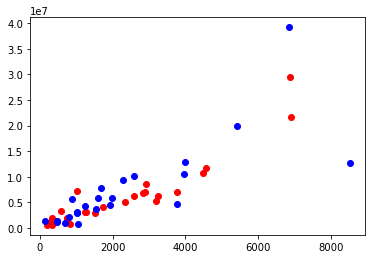

In [212]:
from matplotlib.axis import YAxis
import matplotlib.pyplot as plt

xblue = grouped_states[grouped_states['Gov_Political_Affiliation']=='Democrat']
xred = grouped_states[grouped_states['Gov_Political_Affiliation']=='Republican']
x = xred['incident_count'].values
y = xred['population'].values
plt.scatter(x, y, c='red')
x = xblue['incident_count'].values
y = xblue['population'].values
plt.scatter(x, y, c='blue')

plt.show()


In [230]:
import plotly.express as px

px.pie(grouped_states, names='Gov_Political_Affiliation', color='Gov_Political_Affiliation', color_discrete_map={'Republican':'red',
                                 'Democrat':'blue'}, title="Blue-Red States")



In [247]:
px.box(state_stats1, y ='per_capita', x='Gov_Political_Affiliation', title='Box & Whisker Plot of Per Capita Incidents', hover_data=['state'],\
    labels={'Gov_Political_Affiliation':'State Polticial Leaning', 'per_capita':'gun incidents'})

In [249]:


px.bar(state_stats1.groupby(['Gov_Political_Affiliation'])['per_capita'].mean(), labels={
                     "Gov_Political_Affiliation": "Mean Gun Incidents by Poltical Leaning (States)",
                     "value": "Incidents",
                     "per_capita": "incident average"})